## VJP utils

In [73]:
import numpy as np
import random
import pandas as pd
import time

from sklearn.model_selection import train_test_split

def num_jvp(f, x, v, eps=1e-6):
    """
    Args:
    f: a function returning an array.
    x: an array.
    v: an array (same shape as x).

    Returns:
    numerical_jvp
    """
    if not np.array_equal(x.shape, v.shape):
        raise ValueError("x and v should have the same shape.")

    return (f(x + eps * v) - f(x - eps * v)) / (2 * eps)

def num_jacobian(f, x, eps=1e-6):
    """
    Args:
    f: a function returning an array.
    x: an array (only 1d and 2d arrays supported).

    Returns:
    numerical_jacobian
    """
    def e(i):
        ret = np.zeros_like(x)
        ret[i] = 1
        return ret

    def E(i, j):
        ret = np.zeros_like(x)
        ret[i, j] = 1
        return ret

    if len(x.shape) == 1:
        return np.array([num_jvp(f, x, e(i), eps=eps) for i in range(len(x))]).T
    elif len(x.shape) == 2:
        return np.array([[num_jvp(f, x, E(i, j), eps=eps) \
                     for i in range(x.shape[0])] \
                     for j in range(x.shape[1])]).T
    else:
        raise NotImplementedError

def num_vjp(f, x, u, eps=1e-6):
    """
    Args:
    f: a function returning an array.
    x: an array (only 1d and 2d arrays supported).

    Returns:
    numerical_vjp
    """
    J = num_jacobian(f, x, eps=eps)
    if len(J.shape) == 2:
        return J.T.dot(u)
    elif len(J.shape) == 3:
        shape = J.shape[1:]
        J = J.reshape(J.shape[0], -1)
        return u.dot(J).reshape(shape)
    else:
        raise NotImplementedError


## Vector Jacobian products (VJPs) for basic primitives 

In [37]:
def indentity(x):
    return x


def identity_make_vjp(x):
    def vjp(u):
        return u,
    return vjp

indentity.make_vjp = identity_make_vjp


def dot(x, W):
    return np.dot(W, x)

def dot_make_vjp(x, W):
    def vjp(u):
        return W.T.dot(u), np.outer(u, x)
    return vjp

dot.make_vjp = dot_make_vjp

def squared_loss(y_pred, y):
    return np.array([0.5 * np.sum((y - y_pred) ** 2)])

def squared_loss_make_vjp(y_pred, y):
    diff = y_pred - y

    def vjp(u):
        return u * diff, - u * diff

    return vjp

squared_loss.make_vjp = squared_loss_make_vjp


def bce_loss(y_pred, y, clip=1e-6):
    y_pred = np.clip(y_pred, clip, 1-clip)
    return np.clip(-np.array((y * np.log(y_pred) + (1-y) * np.log(1-y_pred))), clip, 1-clip)


def bce_loss_make_vjp(y_pred, y, threshold=1, clip=1e-6):
    y_pred = np.clip(y_pred, clip, 1-clip)
    diff_pred =  (1-y) / (1-y_pred) - y / y_pred
    diff_param = np.log(1 - y_pred) - np.log(y_pred)
        
    def vjp(u):
        return u * diff_pred, u * diff_param

    return vjp

bce_loss.make_vjp = bce_loss_make_vjp


def cat_cross_entropy_loss(y_pred, y, clip=1e-6):
    y_pred = np.clip(y_pred, clip, 1-clip)
    l = np.sum(y * np.log(y_pred))
    return - np.array([l])

def cat_cross_entropy_loss_make_vjp(y_pred, y, clip=1e-6):
    y_pred = np.clip(y_pred, clip, 1-clip)
    diff_pred = - y / y_pred
    diff_param = - np.log(y_pred)
    
    def vjp(u):
        return u * diff_pred, u * diff_param
    
    return vjp

cat_cross_entropy_loss.make_vjp = cat_cross_entropy_loss_make_vjp


def add(a, b):
    return a + b

def add_make_vjp(a, b):
    gprime = np.ones(len(a))

    def vjp(u):
        return u * gprime, u * gprime

    return vjp

add.make_vjp = add_make_vjp

def mul(a, b):
    return a * b

def mul_make_vjp(a, b):
    gprime_a = b
    gprime_b = a

    def vjp(u):
        return u * gprime_a, u * gprime_b

    return vjp

mul.make_vjp = mul_make_vjp

def exp(x, clip=700):
    x = np.clip(x, -clip, clip)
    return np.exp(x)

def exp_make_vjp(x):
    gprime = exp(x)

    def vjp(u):
        return u * gprime,

    return vjp

exp.make_vjp = exp_make_vjp

def sqrt(x):
    return np.sqrt(x)

def sqrt_make_vjp(x):
    gprime = 1. / (2 * sqrt(x))

    def vjp(u):
        return u * gprime,

    return vjp

sqrt.make_vjp = sqrt_make_vjp

## More functions and VJPs

In [3]:
def relu(x):
     return np.where(x > 0, x, 0)
    
def relu_make_vjp(x):
    gprime = np.where(x > 0, 1, 0)
    
    def vjp(u):
        return u * gprime,
    return vjp

relu.make_vjp = relu_make_vjp


def sigmoid(x, over_clip=700, under_clip=-700):
    x = np.clip(x, under_clip, over_clip)
    return 1 / (1 + np.exp(-x))


def sigmoid_make_vjp(x, over_clip=700, under_clip=-700):
    x = np.clip(x, under_clip, over_clip)
    y = np.exp(-x)
    gprime = y / (1 + y)**2
    
    def vjp(u):
        return u * gprime,
    return vjp

sigmoid.make_vjp = sigmoid_make_vjp


def tanh(x, over_clip=700, under_clip=-700):
    x = np.clip(2 * x, under_clip, over_clip)
    y = np.exp(-x)
    return (1-y)/(1+y)

def tanh_make_vjp(x):
    gprime = 1 - tanh(x)**2
    
    def vjp(u):
        return u * gprime,
    return vjp

tanh.make_vjp = tanh_make_vjp


def softmax(x, over_clip=700, under_clip=-700):
    x = np.clip(x, under_clip, over_clip)
    y = np.exp(x)
    return y / np.sum(y)

def softmax_make_vjp(x):
    y = softmax(x)
    d = np.diag(y)
    y = np.expand_dims(y, axis=1)
    gprime = d - y @ y.T
    
    def vjp(u):
        return gprime @ u,
    return vjp

softmax.make_vjp = softmax_make_vjp

## Reverse differentiation of feedforward networks

In [4]:
def call_func(x, func, param):
    """Make sure the function is called with the correct number of arguments."""

    if param is None:
        # Unary function
        return func(x)
    else:
        # Binary function
        return func(x, param)
    
    
def call_vjp(x, func, param, u):
    """Make sure the vjp is called with the correct number of arguments."""
    if param is None:
        vjp = func.make_vjp(x)
        vjp_x, = vjp(u)
        vjp_param = None
    else:
        vjp = func.make_vjp(x, param)
        vjp_x, vjp_param = vjp(u)
    return vjp_x, vjp_param

## FCN class

In [57]:
class FeedForwardNetwork():
    def __init__(self, loss, input_shape, shapes, activation_functions, use_biases):
        self.loss = loss
        self.input_shape = input_shape
        self.shapes = shapes
        self.activation_functions = activation_functions
        self.use_biases = use_biases
        self.funcs, self.params = self.create_feed_forward(
            self.loss, self.input_shape, self.shapes, self.activation_functions, self.use_biases
        )
        
    def make_layer(self, in_shape, out_shape, use_bias=False):
        W = np.random.randn(out_shape, in_shape).astype(np.float64)
        if use_bias:
            b = np.zeros(out_shape).astype(np.float64)
            return W, b
        else:
            return W, None

    def create_feed_forward(self, loss, input_shape, shapes, activation_functions, use_biases):
        params, funcs = list(), list()
        current_shape = input_shape
        for i in range(len(activation_functions)):
            W, b = self.make_layer(current_shape, shapes[i], use_biases[i])
            params.append(W)
            funcs.append(dot)
            if b is not None:
                params.append(b)
                funcs.append(add)
            params.append(None)
            funcs.append(activation_functions[i])
            current_shape = shapes[i]

        # append fake loss input to make sure that params and funcs have the same length
        params.append(1.0)
        funcs.append(loss)

        return funcs, params
    
    def __call__(self, x, return_loss=False, return_all=False, params=None):
        """
        Evaluate a chain of functions.

        Args:
        x: initial input to the chain.
        funcs: a list of functions of the form func(x) or func(x, param).
        params: a list of parameters, with len(params) = len(funcs).
            If a function doesn't have parameters, use None.
        return_all: whether to return all intermediate values or only the last one.
        return_loss: wether to return loss or model output

        Returns:
        value (return_all == False) or values (return_all=True)
        """
        
        if params is None:
            params = self.params
            
        if len(self.funcs) != len(params):
            raise ValueError("len(funcs) and len(params) should be equal.")
        if return_loss:
            K = len(self.funcs)
        else:
            K = len(self.funcs) - 1
        if return_all:
            X = list()
            X.append(x)
            for k in range(K):
                x = call_func(x, self.funcs[k], params[k])
                X.append(x)
            return X
        else:
            for k in range(K):
                x = call_func(x, self.funcs[k], params[k])
            return x
        
    def backward(self, x, y_truth, params=None):
        """
        Reverse-mode differentiation of a chain of computations.

        Args:
        x: initial input to the chain.
        y_truth: ground truth
        funcs: a list of functions of the form func(x) or func(x, param).
        params: a list of parameters, with len(params) = len(funcs).
                If a function doesn't have parameters, use None.

        Returns:
        value, Jacobian w.r.t. x
        """
        # Evaluate the feedforward model and store intermediate computations,
        # as they will be needed during the backward pass.
        if params is None:
            params = self.params
        
        params[-1] = y_truth
        xs = self.__call__(x, return_loss=True, return_all=True, params=params)
        
        m = xs[-1].shape[0]  # Output size
        K = len(self.funcs)  # Number of functions.

        # We need a list as the shape of U can change.
        U = list(np.eye(m))
        jac_params = list()

        for k in reversed(range(K)):
            V = [call_vjp(xs[k], self.funcs[k], params[k], u) for u in U]

            # update weights or biases auto_diff
            if params[k] is not None:
                jac_params.insert(0, np.asarray([v[1] for v in V])[0])
            else:
                jac_params.insert(0, None)

            # update activation function auto_diff
            U = [v[0] for v in V]

        return xs, np.array(U), jac_params
    
    def update_params(self, jac_params, lr):
        self.params = [p - lr * jp if (p is not None and jp is not None) else None for p, jp in zip(self.params, jac_params)]
        


## Dataset formating

In [60]:
data = pd.read_csv('/home/data_scientist/dataIASD/fashion_lnist/fashion-mnist_train.csv')
train_val, test = train_test_split(data, test_size=0.15)
train, val = train_test_split(train_val, test_size=0.21)

In [56]:
data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,1,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,8,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [187]:
train_images, train_labels = (np.array(train)[:, 1:] / 255.).astype(np.float64), np.array(train)[:, 0]
val_images, val_labels = (np.array(val)[:, 1:] / 255.).astype(np.float64), np.array(val)[:, 0]
test_images, test_labels = (np.array(test)[:, 1:] / 255.).astype(np.float64), np.array(test)[:, 0]

def fashion_mnist_generator(images, labels, batch_size):
    indices = np.random.permutation(len(labels))
    for i in range(0, len(indices), batch_size):
        current_indices = indices[i:i+batch_size]
        current_images, current_labels = images[current_indices, :], to_categorical(labels[current_indices])
        yield current_images, current_labels
        
        
def to_categorical(labels, num_classes=10):
    categorical_labels = np.zeros((len(labels), num_classes))
    for i in range(len(labels)):
        categorical_labels[i, labels[i]] = 1
    return categorical_labels


def soft_thresholding(lmbd, param):
    s1 = np.where(param > lmbd, param - lmbd, 0)
    s2 = np.where(param < - lmbd, param + lmbd, 0)
    return s1 + s2


def get_accuracy(model, images, labels, btch_sz, params=None):
    acc = 0.0
    for imgs, lbls in fashion_mnist_generator(images, labels, btch_sz):
        preds = [model(x, params) for x in imgs]
        acc += np.count_nonzero([np.argmax(p) == np.argmax(l) for p, l in zip(preds, lbls)])
    return acc / len(labels)


## SGD

In [188]:
# n = 28*28
# o_shape = 10
# shapes = [64, 32, 128, o_shape]
# activation_functions = [tanh, tanh, tanh, softmax]
# use_biases = [True, True, True, True]

# n = 28*28
# o_shape = 10
# shapes = [o_shape]
# activation_functions = [softmax]
# use_biases = [False]

n = 28*28
o_shape = 10
shapes = [64, o_shape]
activation_functions = [tanh, softmax]
use_biases = [True, True]

fashion_model = FeedForwardNetwork(cat_cross_entropy_loss, n, shapes, activation_functions, use_biases)

batch_size = 64
lr = 0.008
lr *= batch_size
num_epochs = 4
plot_frequency = 50 * 64 // batch_size

axis = list()
loss_values = list()
accuracies = list()
ridge_reglarisation = False
lasso_regularization = True
lmbd = 0.1

best_params = fashion_model.params
best_acc = 0.0
for e in range(num_epochs):
    for i, (imgs, labels) in enumerate(fashion_mnist_generator(train_images, train_labels, batch_size)):
        t0 = time.time()
        auto_diffs = [fashion_model.backward(x, y) for x, y in zip(imgs, labels)]
        avg_grads = [
            np.average([J[k] for _, _, J in auto_diffs if J[k] is not None], axis=0)
            if auto_diffs[0][2][k] is not None else None for k in range(len(auto_diffs[0][2]))
        ]
        
        if ridge_reglarisation:
            ridge_grads = [2 * lmbd * p if p is not None else None for p in fashion_model.params]
            avg_grads = [a + r if a is not None else None for a, r in zip(avg_grads, ridge_grads)]
        
        elif lasso_regularization:
            lasso_grads = [soft_thresholding(lmbd, p) if p is not None else None for p in fashion_model.params]
            avg_grads = [a + r if a is not None else None for a, r in zip(avg_grads, lasso_grads)]
            
        fashion_model.update_params(avg_grads, lr)
        t1 = time.time()
        if i % plot_frequency == 0:
            t2 = time.time()
            acc = get_accuracy(fashion_model, val_images, val_labels, 128)
            t3 = time.time()
            if acc > best_acc:
                best_acc = acc
                best_params = fashion_model.params
            accuracies.append(acc)
            axis.append(i * batch_size + len(train_labels) * e)
            loss_values.append(np.average([a[0][-1] for a in auto_diffs]))
            print(
                'Epoch {}, {:2f}%, loss = {:2f}, acc = {:2f}%, forward_backward_time = {:2f}s, val_time = {:2f}s'.format(
                    e+1, i * batch_size * 100 / len(train_labels), np.average([a[0][-1] for a in auto_diffs]),
                    acc*100, t1-t0, t3 - t2)
            )

Epoch 1, 0.000000%, loss = 8.106075, acc = 17.740430%, forward_backward_time = 0.091914s, val_time = 1.916928s
Epoch 1, 7.942417%, loss = 0.868008, acc = 65.480859%, forward_backward_time = 0.056427s, val_time = 1.680131s
Epoch 1, 15.884835%, loss = 0.812041, acc = 73.501401%, forward_backward_time = 0.055665s, val_time = 1.661981s
Epoch 1, 23.827252%, loss = 0.981657, acc = 64.304388%, forward_backward_time = 0.056159s, val_time = 1.617275s
Epoch 1, 31.769670%, loss = 1.129290, acc = 66.928105%, forward_backward_time = 0.056238s, val_time = 1.660704s
Epoch 1, 39.712087%, loss = 0.829882, acc = 74.154995%, forward_backward_time = 0.055799s, val_time = 1.666189s
Epoch 1, 47.654505%, loss = 0.696783, acc = 73.155929%, forward_backward_time = 0.073568s, val_time = 1.637586s
Epoch 1, 55.596922%, loss = 0.599907, acc = 72.987862%, forward_backward_time = 0.056588s, val_time = 1.716204s
Epoch 1, 63.539340%, loss = 0.829031, acc = 78.356676%, forward_backward_time = 0.057102s, val_time = 1.65

In [159]:
acc = get_accuracy(fashion_model, test_images, test_labels, 64)
acc

0.735

## Neterov acceleration

In [189]:
n = 28*28
o_shape = 10
shapes = [64, o_shape]
activation_functions = [tanh, softmax]
use_biases = [True, True]

fashion_model_nesterov = FeedForwardNetwork(cat_cross_entropy_loss, n, shapes, activation_functions, use_biases)

batch_size = 64
num_epochs = 4
plot_frequency = 50 * 64 // batch_size

axis = list()
loss_values_nest = list()
accuracies_nest = list()
ridge_reglarisation = False
lasso_regularization = True
# lmbd = 0.003
lmbd = 0.1


grad_params = fashion_model_nesterov.params
lambda_t = 0
L = 3
momentum = [np.zeros_like(p) if p is not None else None for p in fashion_model.params]
best_acc_nest = 0.0
for e in range(num_epochs):
    for i, (imgs, labels) in enumerate(fashion_mnist_generator(train_images, train_labels, batch_size)):
        
            
        t0 = time.time()

        auto_diffs = [fashion_model_nesterov.backward(x, y, params=grad_params) for x, y in zip(imgs, labels)]
        avg_grads = [
            np.average([J[k] for _, _, J in auto_diffs if J[k] is not None], axis=0)
            if auto_diffs[0][2][k] is not None else None for k in range(len(auto_diffs[0][2]))
        ]
        if ridge_reglarisation:
            ridge_grads = [2 * lmbd * p if p is not None else None for p in fashion_model_nesterov.params]
            avg_grads = [a + r if a is not None else None for a, r in zip(avg_grads, ridge_grads)]

        elif lasso_regularization:
            lasso_grads = [soft_thresholding(lmbd, p) if p is not None else None for p in fashion_model_nesterov.params]
            avg_grads = [a + r if a is not None else None for a, r in zip(avg_grads, lasso_grads)]


        new_params = [
            p - grad / L if (p is not None and grad is not None) else None
            for p, grad in zip(fashion_model_nesterov.params, avg_grads)
        ]
        lambda_t1 = (1 + np.sqrt(1 + 4 * lambda_t**2)) / 2
        gamma = lambda_t / lambda_t1
        lambda_t = lambda_t1
        grad_params = [
            new_p + gamma * (new_p - p) if (new_p is not None and p is not None) else None
            for new_p, p in zip(new_params, fashion_model_nesterov.params)
        ]
        fashion_model_nesterov.params = new_params
        t1 = time.time()
        if i % plot_frequency == 0:
            t2 = time.time()
            acc = get_accuracy(fashion_model_nesterov, val_images, val_labels, 128)
            t3 = time.time()
            if acc > best_acc_nest:
                best_acc_nest = acc
                best_params_nest = fashion_model_nesterov.params
            accuracies_nest.append(acc)
            axis.append(i * batch_size + len(train_labels) * e)
            loss_values_nest.append(np.average([a[0][-1] for a in auto_diffs]))
            print(
                'Epoch {}, {:2f}%, loss = {:2f}, acc = {:2f}%, forward_backward_time = {:2f}s, val_time = {:2f}s'.format(
                    e+1, i * batch_size * 100 / len(train_labels), np.average([a[0][-1] for a in auto_diffs]),
                    acc*100, t1-t0, t3 - t2)
            )

Epoch 1, 0.000000%, loss = 9.939213, acc = 11.802054%, forward_backward_time = 0.047441s, val_time = 1.995828s
Epoch 1, 7.942417%, loss = 1.446788, acc = 61.204482%, forward_backward_time = 0.056861s, val_time = 1.701477s
Epoch 1, 15.884835%, loss = 0.885819, acc = 70.018674%, forward_backward_time = 0.058762s, val_time = 1.663136s
Epoch 1, 23.827252%, loss = 1.307022, acc = 64.808590%, forward_backward_time = 0.068195s, val_time = 2.056195s
Epoch 1, 31.769670%, loss = 1.078348, acc = 70.887021%, forward_backward_time = 0.056333s, val_time = 1.668297s
Epoch 1, 39.712087%, loss = 1.035479, acc = 73.323996%, forward_backward_time = 0.062828s, val_time = 1.642779s
Epoch 1, 47.654505%, loss = 0.761697, acc = 77.021475%, forward_backward_time = 0.067820s, val_time = 1.640047s
Epoch 1, 55.596922%, loss = 0.853464, acc = 74.425770%, forward_backward_time = 0.055868s, val_time = 1.689279s
Epoch 1, 63.539340%, loss = 0.959022, acc = 76.451914%, forward_backward_time = 0.057498s, val_time = 1.78

In [160]:
acc = get_accuracy(fashion_model_nesterov, test_images, test_labels, 64)
acc

0.8153333333333334

52
52


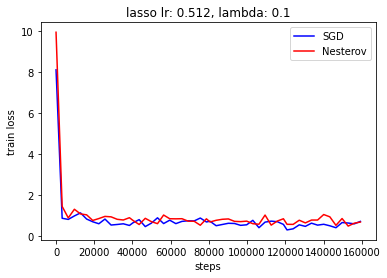

In [190]:
import matplotlib.pyplot as plt

if ridge_reglarisation == True:
    title = 'ridge '
elif lasso_regularization == True:
    title = 'lasso '
else:
    title = ''
print(len(loss_values))
print(len(loss_values_nest))
plt.plot(axis, loss_values, 'b', label='SGD')
plt.plot(axis, loss_values_nest, 'r', label='Nesterov')
plt.ylabel('train loss')
plt.xlabel('steps')
plt.title('{}lr: {}, lambda: {}'.format(title, lr, lmbd))
plt.legend()
plt.show()

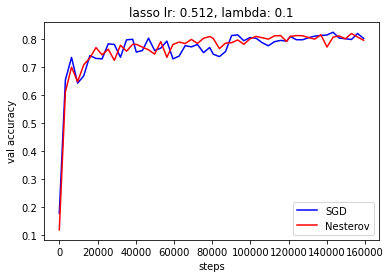

In [191]:
plt.plot(axis, accuracies, color='b', label='SGD')
plt.plot(axis, accuracies_nest, color='r', label='Nesterov')
plt.ylabel('val accuracy')
plt.xlabel('steps')
plt.title('{}lr: {}, lambda: {}'.format(title, lr, lmbd))
plt.legend()
plt.show()